In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 

import matplotlib.pyplot as plt 

import tqdm 

torch.manual_seed(1)
np.random.seed(1)

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [2]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:34<00:00, 769736.09it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 57908.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 514515.56it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6488064.00it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

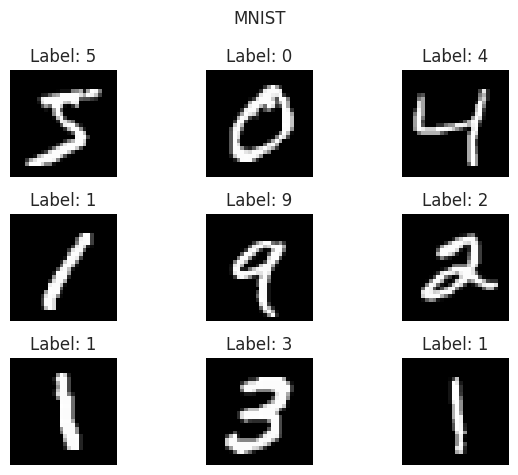

In [4]:
display_nine_images(mnist_trainset)

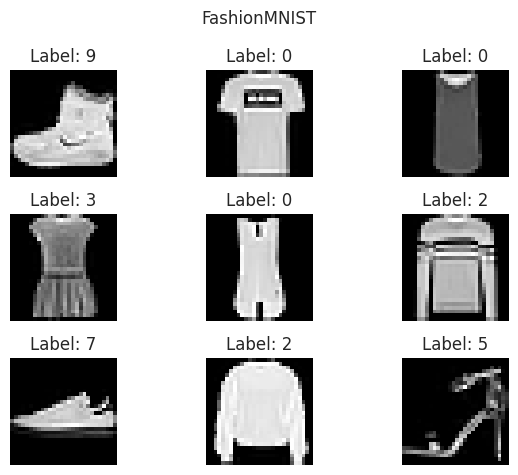

In [5]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [6]:
# implement k-means

def kmeans(X, K, max_iters=100, init='random'):
    N, D = X.shape 
    centroids = torch.zeros(K, D)
    if init == 'random':
        centroids = X[torch.randint(N, (K,))]
    elif init == 'kmeans++':
        centroids[0] = X[torch.randint(N, (1,))]
        for k in range(1, K):
            dists = torch.cdist(X, centroids[:k]).min(dim=1).values
            probs = dists / dists.sum()
            centroids[k] = X[torch.multinomial(probs, 1)]
    elif init == 'mean':
        for k in range(K):
            centroids[k] = X[(y == k).nonzero().squeeze()].mean(dim=0)
    else:
        raise ValueError('Invalid initialization')
    for _ in range(max_iters):
        dists = torch.cdist(X, centroids)
        labels = dists.argmin(dim=1)
        for k in range(K):
            centroids[k] = X[labels == k].mean(dim=0)
    return centroids, labels


In [7]:
# prepare data
X = mnist_trainset.data.view(-1, 28*28).float()
y = mnist_trainset.targets

# run k-means
K = 10

centroids, labels = kmeans(X, K, init='mean')

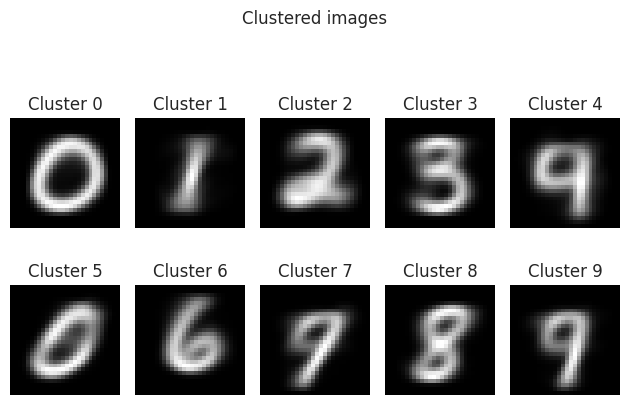

In [8]:
# plot clusters

def plot_clusters(X, labels, centroids):
    for k in range(K):
        plt.subplot(2, 5, k + 1) 
        plt.imshow(centroids[k].view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Cluster {k}')
    plt.suptitle('Centroids')
    plt.tight_layout()  

    for i in range(10):
        plt.subplot(2, 5, i + 1) 
        plt.imshow(X[labels == i].mean(dim=0).view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Cluster {i}')
    plt.suptitle('Clustered images')
    plt.tight_layout()
    
plot_clusters(X, labels, centroids)

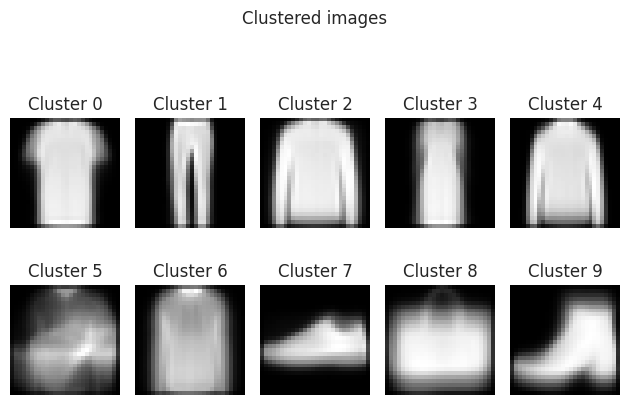

In [9]:
# do the same for fashion mnist
X = fashion_mnist_trainset.data.view(-1, 28*28).float()
y = fashion_mnist_trainset.targets

centroids, labels = kmeans(X, K, init='mean')
plot_clusters(X, labels, centroids)

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [10]:
# train MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

train_loader = DataLoader(mnist_trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=32, shuffle=False)

for epoch in range(5):
    mlp.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat = mlp(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1} Loss: {loss.item()}')
    

Epoch 1 Loss: 0.2341129034757614
Epoch 2 Loss: 0.11289685219526291
Epoch 3 Loss: 0.11340394616127014
Epoch 4 Loss: 0.005147813819348812
Epoch 5 Loss: 0.018628865480422974


In [12]:
# get activations
mlp.eval()
activations = []
for x, y in train_loader:
    activations.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations = np.concatenate(activations)

# fit GMM
gmm = GaussianMixture(n_components=10)
gmm.fit(activations)


GaussianMixture(n_components=10)

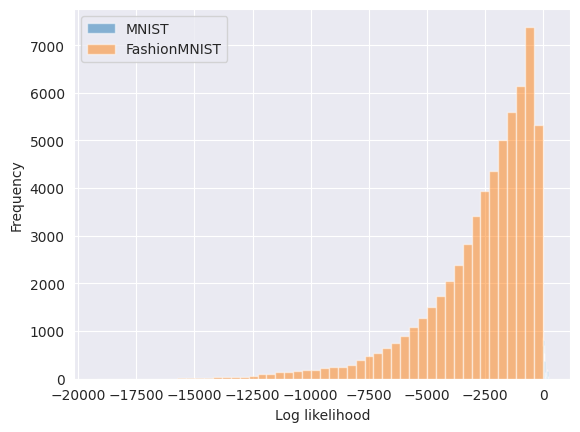

In [14]:
# evaluate GMM
activations_test = []
for x, y in test_loader:
    activations_test.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations_test = np.concatenate(activations_test)

activations_test_fashion = []
for x, y in DataLoader(fashion_mnist_trainset, batch_size=32, shuffle=False):
    activations_test_fashion.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations_test_fashion = np.concatenate(activations_test_fashion)

log_probs = gmm.score_samples(activations_test)
log_probs_fashion = gmm.score_samples(activations_test_fashion)

plt.hist(log_probs, bins=50, alpha=0.5, label='MNIST')
plt.hist(log_probs_fashion, bins=50, alpha=0.5, label='FashionMNIST')
plt.legend()
plt.xlabel('Log likelihood')
plt.ylabel('Frequency')
plt.show()

## Exercício de "papel e caneta"

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 (página 430) do [_Pattern Recognition and Machine Learning_ (C. Bishop)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.